# 🧠 Neural Network Models for Churn Prediction (v2)
## Modular Implementation with Segment-wise Recall Tracking

**استراتژی:**
- 👤 **1-Order Users (45%):** XGBoost
- 👥 **2+ Orders Users (55%):** Neural Networks (MLP, TabNet, FT-Transformer)

**ویژگی‌های کلیدی:**
- ✅ Recall اولویت اصلی
- ✅ نمایش recall هر سگمنت در هر epoch
- ✅ Weighted Recall تجمعی با وزن‌های قابل تنظیم
- ✅ Focal Loss برای داده‌های نامتوازن
- ✅ ساختار ماژولار و تمیز

---

## 0️⃣ Setup

In [6]:
import sys
sys.path.append('..')  # Add parent directory to path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pickle
import json
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Our modules
from src.models import MLP, TabNet, FTTransformer, get_model
from src.training import Trainer, TrainingConfig, FocalLoss
from src.evaluation import MetricsCalculator, SegmentWeights, get_optimal_threshold
from src.data import ChurnDataset, DataConfig, prepare_all_data

# XGBoost for 1-order users
from xgboost import XGBClassifier
from sklearn.metrics import recall_score, f1_score, roc_auc_score

# Settings
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {DEVICE}')

plt.style.use('seaborn-v0_8-whitegrid')

print('✅ All modules loaded!')

Device: cuda
✅ All modules loaded!


## 1️⃣ Configuration

**وزن‌های سگمنت‌ها (قابل تنظیم):**
- هرچه عدد بیشتر = اهمیت بیشتر آن سگمنت در weighted recall

In [7]:
# =============================================================================
# CONFIGURATION
# =============================================================================

DATA_DIR = '../data/processed'
RESULTS_DIR = '../experiments/neural_networks_v2'
Path(RESULTS_DIR).mkdir(parents=True, exist_ok=True)

# وزن‌های سگمنت‌ها برای Weighted Recall
# کاربران با خرید بیشتر = ارزشمندتر = وزن بیشتر
SEGMENT_WEIGHTS = {
    '2-4 Orders': 0.5,      # Base weight
    '5-10 Orders': 1.5,     # 50% more important
    '11-30 Orders': 3.0,    # 2x more important (loyal users)
    '30+ Orders': 5       # 3x more important (VIP users)
}

# Data config
DATA_CONFIG = DataConfig(
    batch_size=256,
    val_size=0.15,
    use_weighted_sampler=True,
    random_state=RANDOM_STATE
)

# Training config
TRAINING_CONFIG = TrainingConfig(
    epochs=100,
    learning_rate=1e-3,
    weight_decay=1e-5,
    patience=15,
    min_delta=0.001,
    gradient_clip=1.0,
    pos_weight=2.0,
    device=str(DEVICE),
    segment_weights=SEGMENT_WEIGHTS
)

print('📋 Configuration:')
print(f'   Segment Weights: {SEGMENT_WEIGHTS}')
print(f'   Epochs: {TRAINING_CONFIG.epochs}')
print(f'   Patience: {TRAINING_CONFIG.patience}')
print(f'   Loss: Focal Loss (better for imbalanced + recall-focused)')

📋 Configuration:
   Segment Weights: {'2-4 Orders': 0.5, '5-10 Orders': 1.5, '11-30 Orders': 3.0, '30+ Orders': 5}
   Epochs: 100
   Patience: 15
   Loss: Focal Loss (better for imbalanced + recall-focused)


## 2️⃣ Load & Prepare Data

In [8]:
# Load and prepare data
dataset = prepare_all_data(DATA_DIR, DATA_CONFIG)

# Prepare NN dataloaders
train_loader, val_loader, test_loader = dataset.prepare_nn_data()

# Get dimensions
input_dim = dataset.get_input_dim()
segments = dataset.get_segment_names()

print(f'\n📊 Data Summary:')
print(f'   Input dim: {input_dim}')
print(f'   Segments (2+ orders): {segments}')

📂 Loading data...
   Train: 254,195 users
   Test:  245,495 users
   Features: 98

📦 Splitting by order count...
   1-Order: Train=102,788, Test=89,442
   Multi:   Train=151,407, Test=156,053

🔧 Encoding categorical features...
   Encoded: []

🔧 Preparing data for Neural Networks...
   Train: 128,695
   Val:   22,712
   Test:  156,053

📊 Data Summary:
   Input dim: 98
   Segments (2+ orders): ['11-30 Orders', '2-4 Orders', '30+ Orders', '5-10 Orders']


In [9]:
# Show segment distribution in validation
print('\n📊 Validation Set Distribution:')
unique, counts = np.unique(dataset.segments_val, return_counts=True)
for seg, count in zip(unique, counts):
    churn_rate = dataset.y_val_nn[dataset.segments_val == seg].mean()
    weight = SEGMENT_WEIGHTS.get(seg, 1.0)
    print(f'   {seg:15s}: {count:,} users ({churn_rate*100:.1f}% churn) - weight: {weight}')


📊 Validation Set Distribution:
   11-30 Orders   : 4,882 users (29.9% churn) - weight: 3.0
   2-4 Orders     : 9,806 users (62.9% churn) - weight: 0.5
   30+ Orders     : 1,287 users (15.2% churn) - weight: 5
   5-10 Orders    : 6,737 users (37.8% churn) - weight: 1.5


---
## 3️⃣ Train XGBoost for 1-Order Users

In [10]:
print('='*80)
print('🌲 Training XGBoost for 1-Order Users')
print('='*80)

# Get 1-order data
X_train_1order, y_train_1order, X_test_1order, y_test_1order = dataset.get_1order_data()

# Calculate class weight
n_churned = y_train_1order.sum()
n_active = len(y_train_1order) - n_churned
scale_pos_weight = n_active / n_churned

print(f'\nClass distribution:')
print(f'   Churned: {n_churned:,} ({n_churned/len(y_train_1order)*100:.1f}%)')
print(f'   Active:  {n_active:,} ({n_active/len(y_train_1order)*100:.1f}%)')
print(f'   scale_pos_weight: {scale_pos_weight:.2f}')

# Train XGBoost with recall-focused eval metric
xgb_1order = XGBClassifier(
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    # eval_metric='aucpr',  # Area Under PR Curve - better for imbalanced data
    eval_metric='logloss',
    early_stopping_rounds=100
)

# Fit without verbose (use callbacks if needed)
xgb_1order.fit(
    X_train_1order, y_train_1order,
    eval_set=[(X_test_1order, y_test_1order)]
)

# Evaluate
y_pred_1order = xgb_1order.predict(X_test_1order)
y_prob_1order = xgb_1order.predict_proba(X_test_1order)[:, 1]

recall_1order = recall_score(y_test_1order, y_pred_1order)
f1_1order = f1_score(y_test_1order, y_pred_1order)
auc_1order = roc_auc_score(y_test_1order, y_prob_1order)

print(f'\n📊 XGBoost Results (1-Order Users):')
print(f'   Recall:  {recall_1order:.4f} ⭐')
print(f'   F1:      {f1_1order:.4f}')
print(f'   ROC-AUC: {auc_1order:.4f}')

🌲 Training XGBoost for 1-Order Users

Class distribution:
   Churned: 92,419 (89.9%)
   Active:  10,369 (10.1%)
   scale_pos_weight: 0.11
[0]	validation_0-logloss:0.68329
[1]	validation_0-logloss:0.67492
[2]	validation_0-logloss:0.66923
[3]	validation_0-logloss:0.66215
[4]	validation_0-logloss:0.65635
[5]	validation_0-logloss:0.65280
[6]	validation_0-logloss:0.64985
[7]	validation_0-logloss:0.64807
[8]	validation_0-logloss:0.64568
[9]	validation_0-logloss:0.64406
[10]	validation_0-logloss:0.64230
[11]	validation_0-logloss:0.64168
[12]	validation_0-logloss:0.64079
[13]	validation_0-logloss:0.63981
[14]	validation_0-logloss:0.63956
[15]	validation_0-logloss:0.63948
[16]	validation_0-logloss:0.63920
[17]	validation_0-logloss:0.63894
[18]	validation_0-logloss:0.63848
[19]	validation_0-logloss:0.63889
[20]	validation_0-logloss:0.63839
[21]	validation_0-logloss:0.63771
[22]	validation_0-logloss:0.63787
[23]	validation_0-logloss:0.63732
[24]	validation_0-logloss:0.63777
[25]	validation_0-logl

---
## 4️⃣ Train Neural Networks (2+ Orders)

### 4.1 MLP

In [11]:
print('='*80)
print('🧠 Training MLP')
print('='*80)

# Create model
mlp_model = get_model('MLP', input_dim, hidden_dims=[256, 128, 64], dropout=0.3)
print(f'\nModel: {mlp_model}')

# Create trainer with Focal Loss (better for recall)
# mlp_trainer = Trainer(mlp_model, TRAINING_CONFIG, loss_fn='focal')
mlp_trainer = Trainer(mlp_model, TRAINING_CONFIG, loss_fn='bce')

# Train with segment-wise tracking
mlp_history = mlp_trainer.train(
    train_loader, val_loader, 
    val_segments=dataset.segments_val,
    print_every=5
)

🧠 Training MLP

Model: MLP(input_dim=98, hidden_dims=[256, 128, 64], params=67,653)

🚀 Starting Training
Device: cuda
Epochs: 100
Patience: 15
Segment Weights: {'2-4 Orders': 0.5, '5-10 Orders': 1.5, '11-30 Orders': 3.0, '30+ Orders': 5}

Epoch   1/100 | Train Loss: 1.4469 | Val Loss: 0.8568
           Segment Recalls: 11-30 Orders: 0.4867 | 2-4 Orders: 0.9901 | 30+ Orders: 0.0769 | 5-10 Orders: 0.8774
           Weighted Recall: 0.3656 | Overall Recall: 0.8743
--------------------------------------------------------------------------------
Epoch   5/100 | Train Loss: 0.8338 | Val Loss: 0.8280
           Segment Recalls: 11-30 Orders: 0.6283 | 2-4 Orders: 0.9934 | 30+ Orders: 0.4000 | 5-10 Orders: 0.8888
           Weighted Recall: 0.5715 | Overall Recall: 0.9051
--------------------------------------------------------------------------------
Epoch  10/100 | Train Loss: 0.8172 | Val Loss: 0.8207
           Segment Recalls: 11-30 Orders: 0.6057 | 2-4 Orders: 0.9898 | 30+ Orders: 0.4359 

### 4.2 TabNet

In [12]:
print('='*80)
print('🧠 Training TabNet')
print('='*80)

# Create model
tabnet_model = get_model('TabNet', input_dim, n_steps=3, n_d=64, n_a=64)
print(f'\nModel: {tabnet_model}')

# Create trainer
tabnet_trainer = Trainer(tabnet_model, TRAINING_CONFIG, loss_fn='bce')

# Train
tabnet_history = tabnet_trainer.train(
    train_loader, val_loader,
    val_segments=dataset.segments_val,
    print_every=5
)

🧠 Training TabNet

Model: TabNet(input_dim=98, n_steps=3, n_d=64, n_a=64, params=71,671)

🚀 Starting Training
Device: cuda
Epochs: 100
Patience: 15
Segment Weights: {'2-4 Orders': 0.5, '5-10 Orders': 1.5, '11-30 Orders': 3.0, '30+ Orders': 5}

Epoch   1/100 | Train Loss: 0.8506 | Val Loss: 0.8340
           Segment Recalls: 11-30 Orders: 0.5756 | 2-4 Orders: 0.9924 | 30+ Orders: 0.3179 | 5-10 Orders: 0.8633
           Weighted Recall: 0.5108 | Overall Recall: 0.8893
--------------------------------------------------------------------------------
Epoch   5/100 | Train Loss: 0.8082 | Val Loss: 0.8336
           Segment Recalls: 11-30 Orders: 0.6023 | 2-4 Orders: 0.9940 | 30+ Orders: 0.4769 | 5-10 Orders: 0.8676
           Weighted Recall: 0.5990 | Overall Recall: 0.8981
--------------------------------------------------------------------------------
Epoch  10/100 | Train Loss: 0.7982 | Val Loss: 0.8312
           Segment Recalls: 11-30 Orders: 0.5914 | 2-4 Orders: 0.9916 | 30+ Orders: 0.

### 4.3 FT-Transformer

In [24]:
print('='*80)
print('🧠 Training FT-Transformer')
print('='*80)

# Create model
ft_model = get_model('FTTransformer', input_dim, d_token=64, n_blocks=3, n_heads=4)
print(f'\nModel: {ft_model}')

# Transformer needs lower learning rate
ft_config = TrainingConfig(
    epochs=100,
    learning_rate=5e-4,  # Lower LR for transformer
    weight_decay=1e-5,
    patience=40,
    min_delta=0.001,
    gradient_clip=1.0,
    pos_weight=2.0,
    device=str(DEVICE),
    segment_weights=SEGMENT_WEIGHTS
)

# Create trainer
ft_trainer = Trainer(ft_model, ft_config, loss_fn='bce')

# Train
ft_history = ft_trainer.train(
    train_loader, val_loader,
    val_segments=dataset.segments_val,
    print_every=5
)

🧠 Training FT-Transformer

Model: FTTransformer(num_features=98, d_token=64, n_blocks=3, params=117,377)

🚀 Starting Training
Device: cuda
Epochs: 100
Patience: 40
Segment Weights: {'2-4 Orders': 0.5, '5-10 Orders': 1.5, '11-30 Orders': 3.0, '30+ Orders': 5}

Epoch   1/100 | Train Loss: 0.8370 | Val Loss: 0.8285
           Segment Recalls: 11-30 Orders: 0.7146 | 2-4 Orders: 0.9964 | 30+ Orders: 0.5846 | 5-10 Orders: 0.8955
           Weighted Recall: 0.6908 | Overall Recall: 0.9242
--------------------------------------------------------------------------------
Epoch   5/100 | Train Loss: 0.8139 | Val Loss: 0.8256
           Segment Recalls: 11-30 Orders: 0.6947 | 2-4 Orders: 0.9934 | 30+ Orders: 0.4667 | 5-10 Orders: 0.8361
           Weighted Recall: 0.6168 | Overall Recall: 0.9028
--------------------------------------------------------------------------------
Epoch  10/100 | Train Loss: 0.8047 | Val Loss: 0.8260
           Segment Recalls: 11-30 Orders: 0.7515 | 2-4 Orders: 0.9987 

---
## 5️⃣ Evaluation on Test Set

In [25]:
print('='*80)
print('📊 Evaluation on Test Set')
print('='*80)

# Initialize metrics calculator
metrics_calc = MetricsCalculator(SegmentWeights(SEGMENT_WEIGHTS))

# Store results
results = {}

# Evaluate each NN model
models_to_eval = [
    ('MLP', mlp_trainer),
    ('TabNet', tabnet_trainer),
    ('FT-Transformer', ft_trainer)
]

for model_name, trainer in models_to_eval:
    print(f'\n📊 {model_name}:')
    
    # Get predictions
    preds, probs = trainer.predict(test_loader)
    
    # Calculate all metrics
    all_metrics = metrics_calc.calculate_all_metrics(
        dataset.y_test_nn, preds, probs, dataset.segments_test
    )
    
    # Display
    print(f'   Overall Recall:  {all_metrics["overall"]["recall"]:.4f}')
    print(f'   Weighted Recall: {all_metrics["weighted_recall"]:.4f} ⭐')
    print(f'   F1:              {all_metrics["overall"]["f1"]:.4f}')
    print(f'   ROC-AUC:         {all_metrics["overall"]["roc_auc"]:.4f}')
    print(f'   \n   Per-segment Recall:')
    for seg, metrics in sorted(all_metrics['per_segment'].items()):
        print(f'      {seg:15s}: {metrics["recall"]:.4f}')
    
    results[model_name] = {
        'predictions': preds,
        'probabilities': probs,
        'metrics': all_metrics
    }

📊 Evaluation on Test Set

📊 MLP:
   Overall Recall:  0.8768
   Weighted Recall: 0.5901 ⭐
   F1:              0.6574
   ROC-AUC:         0.7654
   
   Per-segment Recall:
      11-30 Orders   : 0.6105
      2-4 Orders     : 0.9897
      30+ Orders     : 0.4582
      5-10 Orders    : 0.8562

📊 TabNet:
   Overall Recall:  0.8477
   Weighted Recall: 0.5387 ⭐
   F1:              0.6593
   ROC-AUC:         0.7629
   
   Per-segment Recall:
      11-30 Orders   : 0.5286
      2-4 Orders     : 0.9840
      30+ Orders     : 0.4176
      5-10 Orders    : 0.8140

📊 FT-Transformer:
   Overall Recall:  0.9029
   Weighted Recall: 0.6482 ⭐
   F1:              0.6508
   ROC-AUC:         0.7610
   
   Per-segment Recall:
      11-30 Orders   : 0.6880
      2-4 Orders     : 0.9958
      30+ Orders     : 0.5178
      5-10 Orders    : 0.8873


In [26]:
# Compare all models (including XGBoost for 1-order)
print('\n' + '='*80)
print('📊 COMPLETE COMPARISON')
print('='*80)

comparison_data = []

# Add 1-order XGBoost
comparison_data.append({
    'Model': 'XGBoost',
    'Group': '1-Order',
    'Recall': recall_1order,
    'F1': f1_1order,
    'ROC-AUC': auc_1order,
    'Weighted Recall': recall_1order  # Single segment
})

# Add NN models
for model_name, result in results.items():
    comparison_data.append({
        'Model': model_name,
        'Group': '2+ Orders',
        'Recall': result['metrics']['overall']['recall'],
        'F1': result['metrics']['overall']['f1'],
        'ROC-AUC': result['metrics']['overall']['roc_auc'],
        'Weighted Recall': result['metrics']['weighted_recall']
    })

comparison_df = pd.DataFrame(comparison_data)
display(comparison_df.round(4))


📊 COMPLETE COMPARISON


,Model,Group,Recall,F1,ROC-AUC,Weighted Recall
0,XGBoost,1-Order,0.7484,0.8267,0.6984,0.7484
1,MLP,2+ Orders,0.8768,0.6574,0.7654,0.5901
2,TabNet,2+ Orders,0.8477,0.6593,0.7629,0.5387
3,FT-Transformer,2+ Orders,0.9029,0.6508,0.7610,0.6482


In [27]:
# Per-segment recall comparison
print('\n📊 Per-Segment Recall Comparison (2+ Orders Models):')

segment_comparison = {'Segment': list(SEGMENT_WEIGHTS.keys())}

for model_name, result in results.items():
    segment_comparison[model_name] = [
        result['metrics']['per_segment'].get(seg, {}).get('recall', 0)
        for seg in SEGMENT_WEIGHTS.keys()
    ]

segment_df = pd.DataFrame(segment_comparison)
segment_df['Weight'] = [SEGMENT_WEIGHTS[seg] for seg in SEGMENT_WEIGHTS.keys()]
display(segment_df.round(4))


📊 Per-Segment Recall Comparison (2+ Orders Models):


,Segment,MLP,TabNet,FT-Transformer,Weight
0,2-4 Orders,0.9897,0.9840,0.9958,0.5
1,5-10 Orders,0.8562,0.8140,0.8873,1.5
2,11-30 Orders,0.6105,0.5286,0.6880,3.0
3,30+ Orders,0.4582,0.4176,0.5178,5.0


In [28]:
    # Best model selection
print('\n🏆 BEST MODEL SELECTION:')

# Best NN for 2+ orders (by weighted recall)
nn_weighted_recalls = {name: r['metrics']['weighted_recall'] for name, r in results.items()}
best_nn = max(nn_weighted_recalls, key=nn_weighted_recalls.get)

print(f'\n   Best NN (2+ Orders): {best_nn}')
print(f'   Weighted Recall: {nn_weighted_recalls[best_nn]:.4f}')

# Calculate overall combined performance
print(f'\n📊 Combined Performance (XGBoost + {best_nn}):')

best_result = results[best_nn]
all_y_true = np.concatenate([y_test_1order.values, dataset.y_test_nn])
all_y_pred = np.concatenate([y_pred_1order, best_result['predictions']])
all_y_prob = np.concatenate([y_prob_1order, best_result['probabilities']])

combined_recall = recall_score(all_y_true, all_y_pred)
combined_f1 = f1_score(all_y_true, all_y_pred)
combined_auc = roc_auc_score(all_y_true, all_y_prob)

print(f'   Overall Recall:  {combined_recall:.4f}')
print(f'   Overall F1:      {combined_f1:.4f}')
print(f'   Overall ROC-AUC: {combined_auc:.4f}')


🏆 BEST MODEL SELECTION:

   Best NN (2+ Orders): FT-Transformer
   Weighted Recall: 0.6482

📊 Combined Performance (XGBoost + FT-Transformer):
   Overall Recall:  0.8179
   Overall F1:      0.7289
   Overall ROC-AUC: 0.6311


---
## 6️⃣ Visualizations

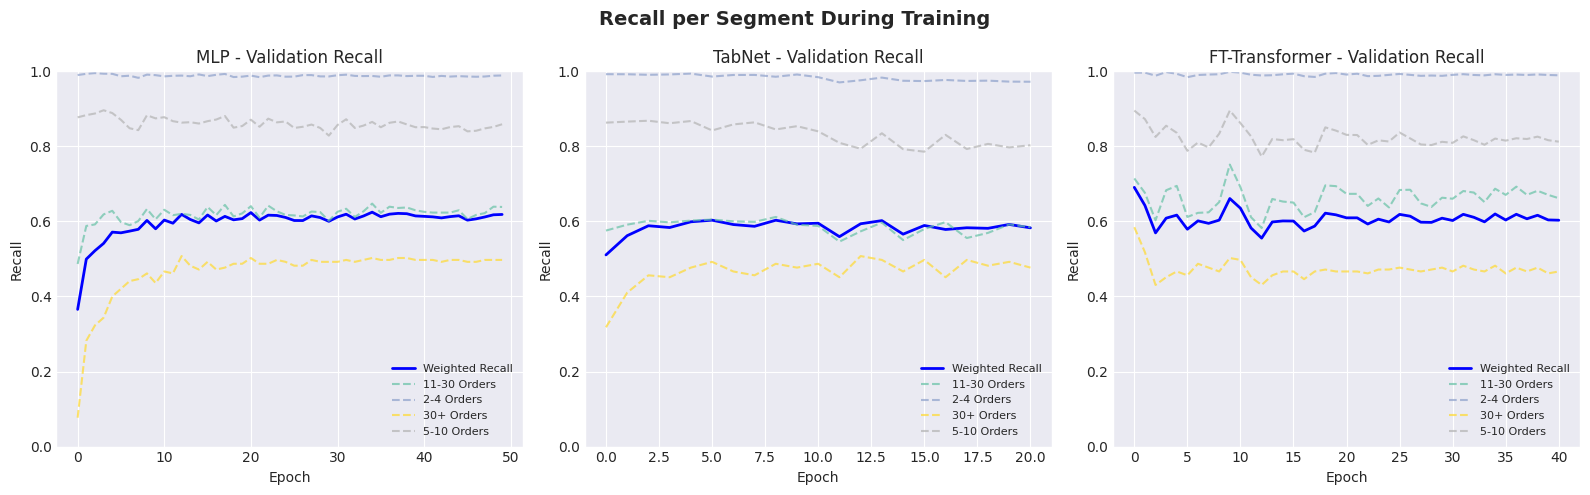

In [29]:
# Training history - Weighted Recall
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

histories = {
    'MLP': mlp_history,
    'TabNet': tabnet_history,
    'FT-Transformer': ft_history
}

for idx, (name, history) in enumerate(histories.items()):
    ax = axes[idx]
    
    # Plot weighted recall
    ax.plot(history['val_weighted_recall'], 'b-', linewidth=2, label='Weighted Recall')
    
    # Plot segment recalls
    colors = plt.cm.Set2(np.linspace(0, 1, len(history['val_segment_recall'])))
    for i, (seg, recalls) in enumerate(history['val_segment_recall'].items()):
        ax.plot(recalls, '--', color=colors[i], alpha=0.7, label=seg)
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Recall')
    ax.set_title(f'{name} - Validation Recall')
    ax.legend(loc='lower right', fontsize=8)
    ax.set_ylim([0, 1])

plt.suptitle('Recall per Segment During Training', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

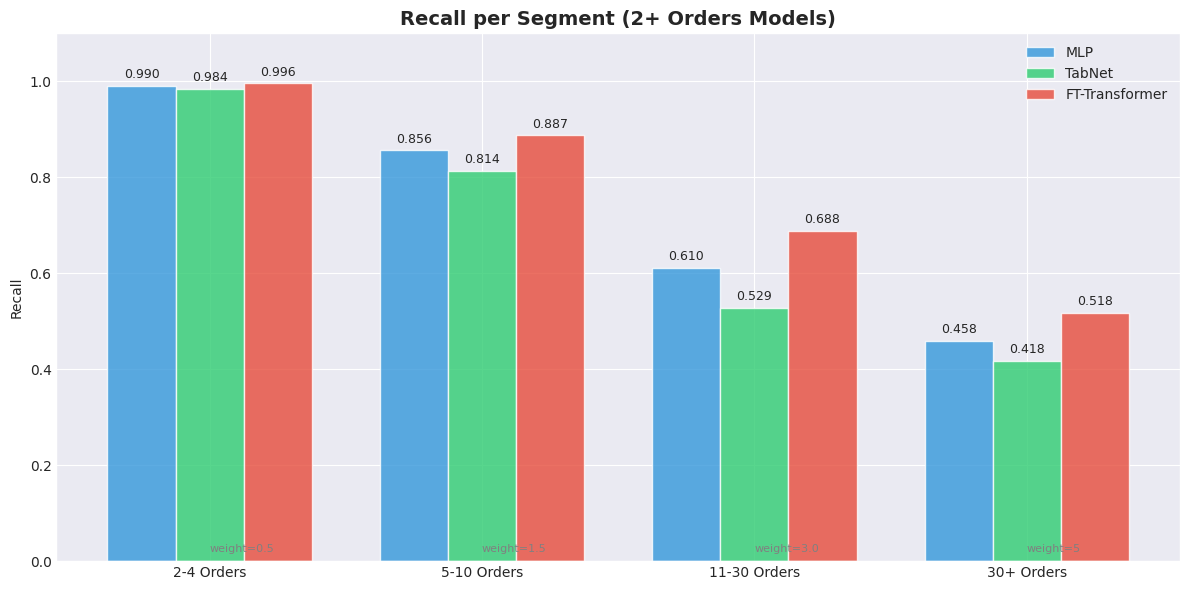

In [30]:
# Per-segment recall bar chart
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(SEGMENT_WEIGHTS))
width = 0.25
colors = ['#3498db', '#2ecc71', '#e74c3c']

for i, (model_name, result) in enumerate(results.items()):
    recalls = [result['metrics']['per_segment'].get(seg, {}).get('recall', 0)
               for seg in SEGMENT_WEIGHTS.keys()]
    bars = ax.bar(x + i*width, recalls, width, label=model_name, color=colors[i], alpha=0.8)
    
    # Add value labels
    for bar, val in zip(bars, recalls):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{val:.3f}', ha='center', va='bottom', fontsize=9)

ax.set_xticks(x + width)
ax.set_xticklabels(SEGMENT_WEIGHTS.keys())
ax.set_ylabel('Recall')
ax.set_title('Recall per Segment (2+ Orders Models)', fontsize=14, fontweight='bold')
ax.legend()
ax.set_ylim([0, 1.1])

# Add weight annotations
for i, (seg, weight) in enumerate(SEGMENT_WEIGHTS.items()):
    ax.annotate(f'weight={weight}', (i + width, 0.02), fontsize=8, color='gray')

plt.tight_layout()
plt.show()

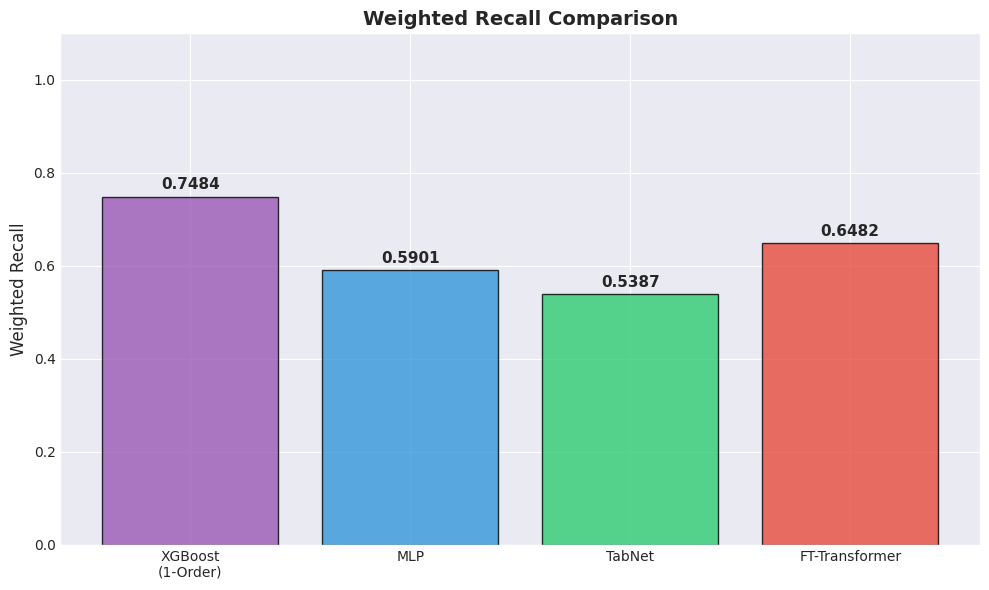

In [31]:
# Weighted recall comparison
fig, ax = plt.subplots(figsize=(10, 6))

models = ['XGBoost\n(1-Order)'] + list(results.keys())
weighted_recalls = [recall_1order] + [r['metrics']['weighted_recall'] for r in results.values()]
colors = ['#9b59b6', '#3498db', '#2ecc71', '#e74c3c']

bars = ax.bar(models, weighted_recalls, color=colors, alpha=0.8, edgecolor='black')

for bar, val in zip(bars, weighted_recalls):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{val:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_ylabel('Weighted Recall', fontsize=12)
ax.set_title('Weighted Recall Comparison', fontsize=14, fontweight='bold')
ax.set_ylim([0, 1.1])

plt.tight_layout()
plt.show()

---
## 7️⃣ Save Models & Results

In [32]:
print('='*80)
print('💾 Saving Models & Results')
print('='*80)

results_path = Path(RESULTS_DIR)

# Save XGBoost
with open(results_path / 'xgboost_1order.pkl', 'wb') as f:
    pickle.dump(xgb_1order, f)
print('✅ Saved: xgboost_1order.pkl')

# Save NN models
torch.save(mlp_trainer.model.state_dict(), results_path / 'mlp_model.pt')
torch.save(tabnet_trainer.model.state_dict(), results_path / 'tabnet_model.pt')
torch.save(ft_trainer.model.state_dict(), results_path / 'ft_transformer_model.pt')
print('✅ Saved: Neural network models (.pt)')

# Save scaler
with open(results_path / 'scaler.pkl', 'wb') as f:
    pickle.dump(dataset.scaler, f)
print('✅ Saved: scaler.pkl')

# Save results
comparison_df.to_csv(results_path / 'model_comparison.csv', index=False)
segment_df.to_csv(results_path / 'segment_recall_comparison.csv', index=False)
print('✅ Saved: comparison CSVs')

# Save config
config_to_save = {
    'segment_weights': SEGMENT_WEIGHTS,
    'training_config': {
        'epochs': TRAINING_CONFIG.epochs,
        'learning_rate': TRAINING_CONFIG.learning_rate,
        'patience': TRAINING_CONFIG.patience,
        'loss_fn': 'focal'
    },
    'best_nn_model': best_nn,
    'combined_metrics': {
        'recall': combined_recall,
        'f1': combined_f1,
        'roc_auc': combined_auc
    }
}

with open(results_path / 'config.json', 'w') as f:
    json.dump(config_to_save, f, indent=2)
print('✅ Saved: config.json')

💾 Saving Models & Results
✅ Saved: xgboost_1order.pkl
✅ Saved: Neural network models (.pt)
✅ Saved: scaler.pkl
✅ Saved: comparison CSVs
✅ Saved: config.json


In [33]:
print('='*80)
print('📋 FINAL SUMMARY')
print('='*80)

print(f'''
🎯 STRATEGY:
   - 1-Order Users: XGBoost (no behavioral patterns)
   - 2+ Orders Users: Neural Networks (rich patterns)

📊 SEGMENT WEIGHTS (for Weighted Recall):
''')
for seg, weight in SEGMENT_WEIGHTS.items():
    print(f'   {seg:15s}: {weight}')

print(f'''
📊 RESULTS:

👤 1-Order (XGBoost):
   Recall: {recall_1order:.4f}

👥 2+ Orders (Neural Networks):
''')
for model_name, result in results.items():
    wr = result['metrics']['weighted_recall']
    r = result['metrics']['overall']['recall']
    print(f'   {model_name:15s}: Recall={r:.4f}, Weighted Recall={wr:.4f}')

print(f'''
🏆 BEST COMBINATION: XGBoost + {best_nn}
   Combined Recall:  {combined_recall:.4f}
   Combined F1:      {combined_f1:.4f}
   Combined ROC-AUC: {combined_auc:.4f}

💾 SAVED TO: {RESULTS_DIR}
''')

📋 FINAL SUMMARY

🎯 STRATEGY:
   - 1-Order Users: XGBoost (no behavioral patterns)
   - 2+ Orders Users: Neural Networks (rich patterns)

📊 SEGMENT WEIGHTS (for Weighted Recall):

   2-4 Orders     : 0.5
   5-10 Orders    : 1.5
   11-30 Orders   : 3.0
   30+ Orders     : 5

📊 RESULTS:

👤 1-Order (XGBoost):
   Recall: 0.7484

👥 2+ Orders (Neural Networks):

   MLP            : Recall=0.8768, Weighted Recall=0.5901
   TabNet         : Recall=0.8477, Weighted Recall=0.5387
   FT-Transformer : Recall=0.9029, Weighted Recall=0.6482

🏆 BEST COMBINATION: XGBoost + FT-Transformer
   Combined Recall:  0.8179
   Combined F1:      0.7289
   Combined ROC-AUC: 0.6311

💾 SAVED TO: ../experiments/neural_networks_v2



---
## 8️⃣ Threshold Optimization (برای بهبود Recall)

In [34]:
print('='*80)
print('🎯 Threshold Optimization for Maximum Recall')
print('='*80)

# Find optimal threshold for recall
best_result = results[best_nn]

optimal_threshold, best_recall = get_optimal_threshold(
    dataset.y_test_nn, 
    best_result['probabilities'],
    metric='recall'
)

print(f'\nOptimal threshold for maximum recall: {optimal_threshold:.2f}')
print(f'Recall at optimal threshold: {best_recall:.4f}')

# Compare with default threshold
default_recall = results[best_nn]['metrics']['overall']['recall']
print(f'\nComparison:')
print(f'   Default (0.5): Recall = {default_recall:.4f}')
print(f'   Optimal ({optimal_threshold:.2f}): Recall = {best_recall:.4f}')
print(f'   Improvement: +{(best_recall - default_recall)*100:.1f}%')

🎯 Threshold Optimization for Maximum Recall

Optimal threshold for maximum recall: 0.10
Recall at optimal threshold: 1.0000

Comparison:
   Default (0.5): Recall = 0.9029
   Optimal (0.10): Recall = 1.0000
   Improvement: +9.7%
